<img src="board_photo.jpg" width=250 />

In [192]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [193]:
# start -> end cells for all snakes and ladders
JUMPS = {
    1: 38,
    4: 14,
    9: 31,
    16: 6,
    21: 42,
    28: 84,
    36: 44,
    47: 26,
    49: 11,
    51: 67,
    56: 53,
    62: 19,
    64: 60,
    71: 91,
    80: 100,
    87: 24,
    93: 73,
    95: 75,
    98: 78,
}

FINISH = 100 # Finish cell

In [194]:
def move(start, rolled):
    assert 0 <= start <= FINISH
    if start == FINISH:
        return FINISH # stay on the finish square if already finished
    new = start + rolled
    if new > FINISH:
        new = FINISH - (new - FINISH) # bounce off the finish square if overrolled
    return JUMPS.get(new, new)

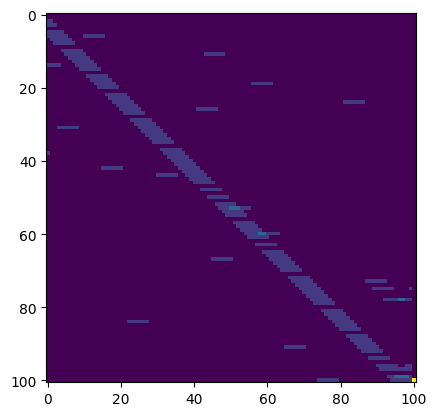

In [195]:
MAX_ROLL = 6 # d6 roll

# move_matrix[new, start] ::= probability to end up in cell `new` in one move from cell `start`
def move_matrix():
    ret = np.zeros((FINISH+1, FINISH+1)) # +1 to accomodate both 0 and FINISH cells
    for start in range(FINISH+1):
        for rolled in range(1, MAX_ROLL+1):
            new = move(start, rolled)
            ret[new,start] += 1/MAX_ROLL
    return ret

MOVE_MATRIX = move_matrix()
plt.imshow(MOVE_MATRIX, interpolation='none', origin='upper')
plt.show()

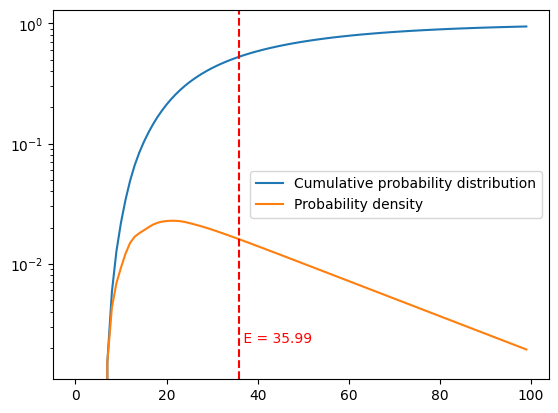

In [196]:
fig, ax = plt.subplots()

# Yields lists of probabilities to end to end up in each cell
# after N moves, for each N in 0..inf
def positions_prob():
    current = np.zeros((FINISH+1, 1))
    current[0,0] = 1

    while True:
        yield current
        current = np.matmul(MOVE_MATRIX, current)

# prob_to_finish[x] ::= probability to finish in `x` moves or less
def prob_to_finish(limit=100):
    current = np.zeros((FINISH+1, 1))
    current[0,0] = 1
    ret = []
    for ps in itertools.islice(positions_prob(), limit):
        ret.append(ps[-1, 0])
    return ret

PROB_TO_FINISH = prob_to_finish()
plt.semilogy(PROB_TO_FINISH, label='Cumulative probability distribution')

def prob_density(probs):
    return [0] + [probs[i]-probs[i-1] for i in range(1, len(probs))]
plt.semilogy(prob_density(PROB_TO_FINISH), label='Probability density')


def expexted(probs):
    return sum(i*p for i,p in enumerate(probs))
E = expexted(prob_density(PROB_TO_FINISH))

trans = ax.get_xaxis_transform()
plt.axvline(E, color='r', linestyle='--')
plt.text(E, .1, f' E = {E:.2f}', transform=trans, color='r')

plt.legend()
plt.show()

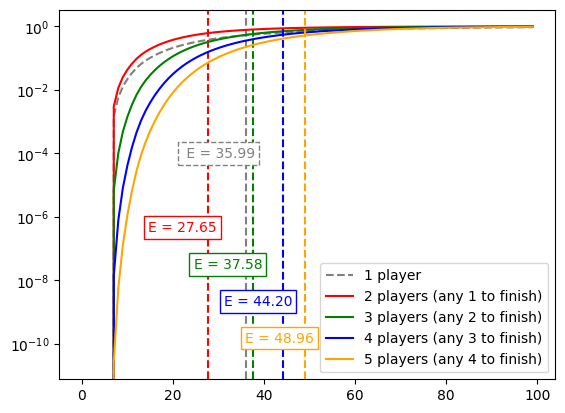

In [199]:
# Transforms a list of probabilities for 1 player
# in a list of probs for a game with N players to finish,
# that is for at least N-1 players to reach the finish cell
# (all but the last player).
def n_players_prob(probs, n):
    return [p**(n-1)*(1-p)*n + p**n for p in probs]

fig, ax = plt.subplots()
trans = ax.get_xaxis_transform()

plt.semilogy(PROB_TO_FINISH, color='grey', linestyle='dashed',
    label=f"1 player")
plt.axvline(E, color='grey', linestyle='--')
plt.text(E+2, .6, f'E = {E:.2f}', transform=trans, color='grey',
    horizontalalignment='right',
    bbox={
        'boxstyle': 'square',
        'facecolor': 'white',
        'edgecolor': 'grey',
        'linestyle': '--',
    })

for n, c in (
    (2, 'red'), (3, 'green'), (4, 'blue'), (5, 'orange')
):
    probs = n_players_prob(PROB_TO_FINISH, n)
    plt.semilogy(probs, color=c, label=f"{n} players (any {n-1} to finish)")
    _E = expexted(prob_density(probs))
    plt.axvline(_E, color=c, linestyle='--')
    plt.text(_E+2, .6 - .1*n, f'E = {_E:.2f}', transform=trans, color=c,
        horizontalalignment='right',
        bbox={
            'boxstyle': 'square',
            'facecolor': 'white',
            'edgecolor': c,
        })

plt.legend()    
plt.show()

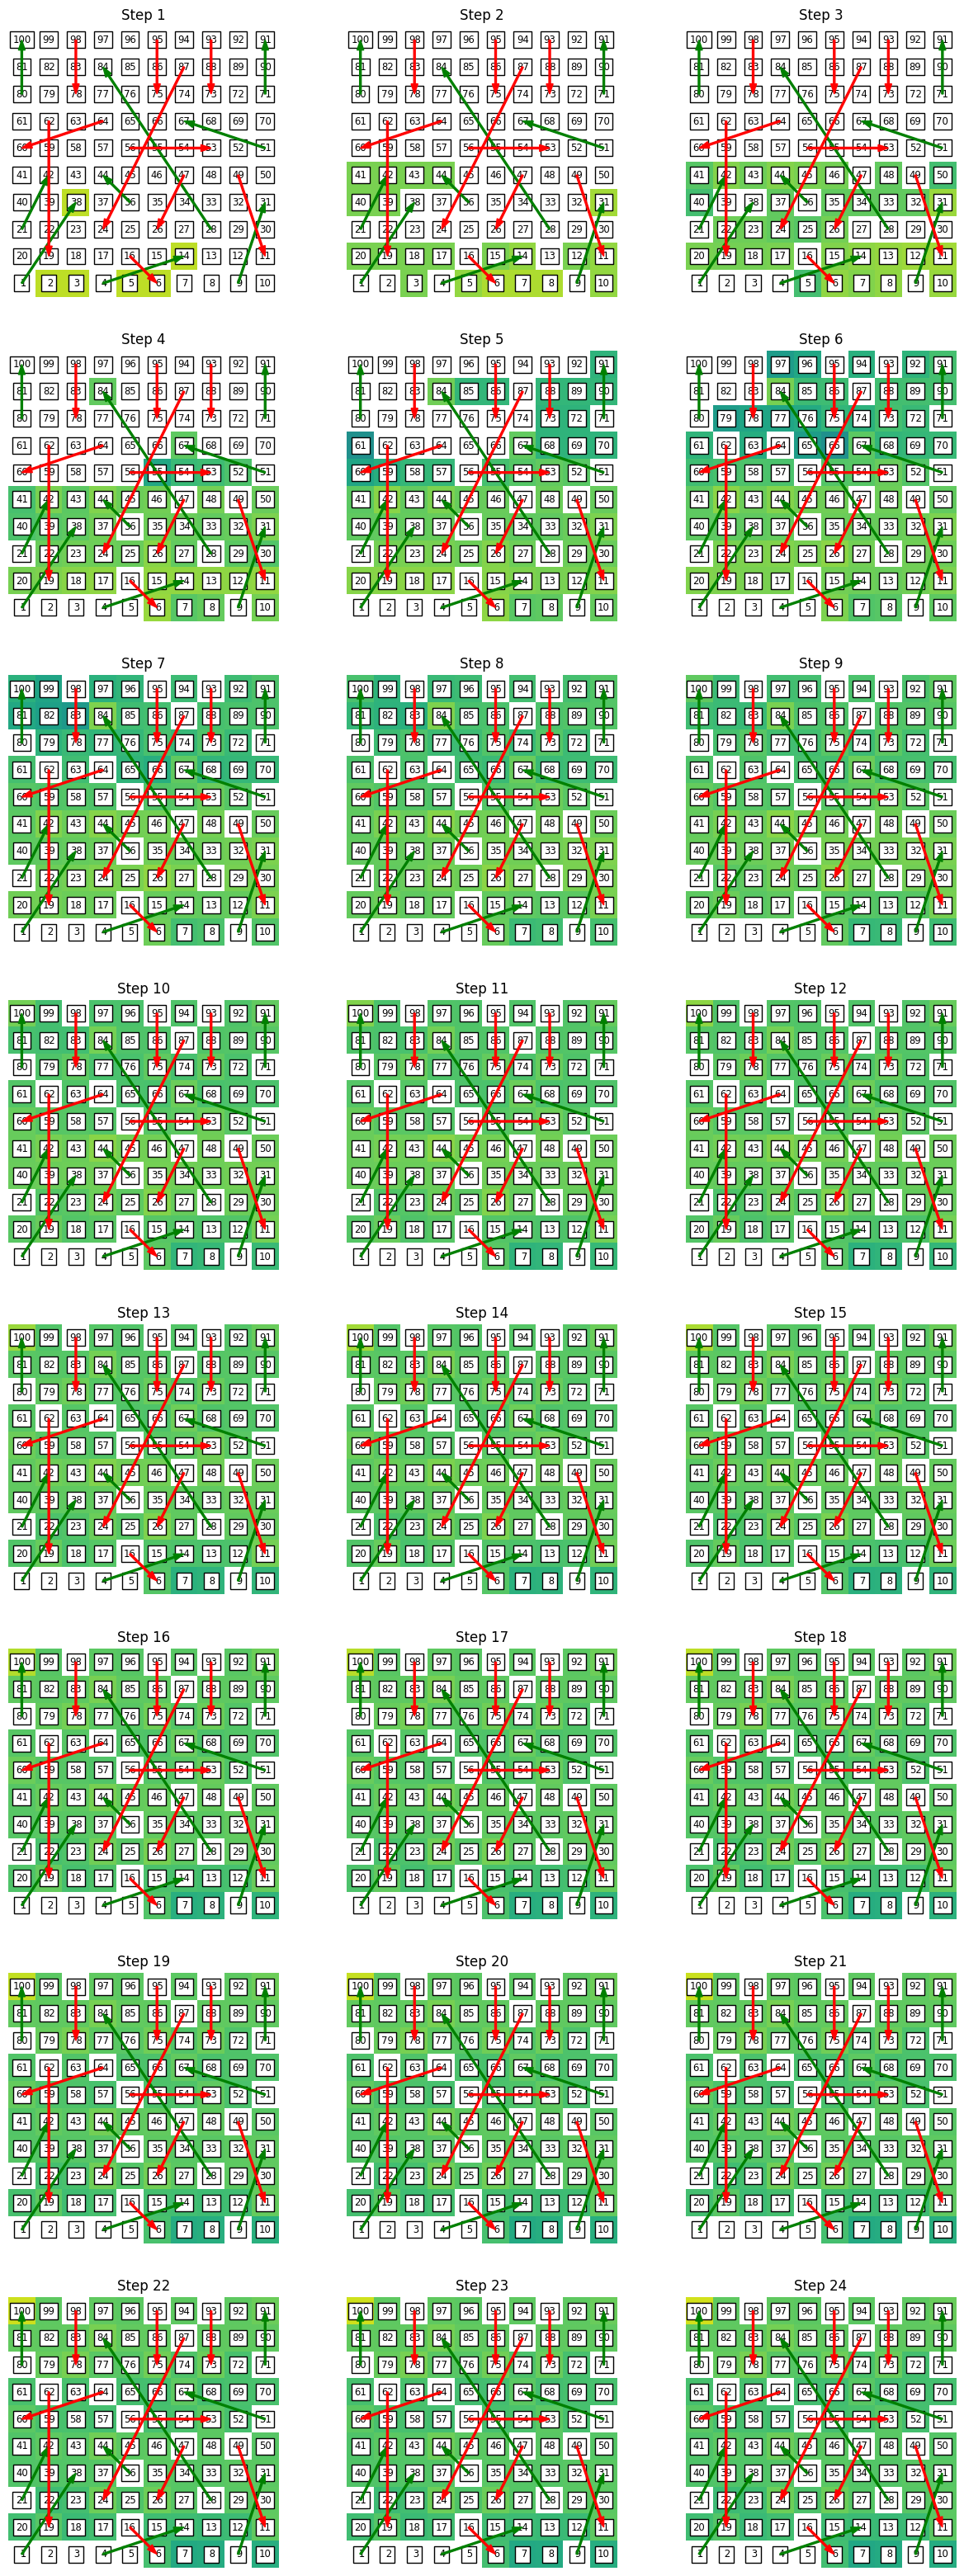

In [198]:
import math

SIZE = 10 # Board dimsnsions

def draw_board_probs(probs, rows, columns, step):
    plt.subplot(rows, columns, step)
    plt.axis('off')
    plt.title(f'Step {step}')
    board = [[(probs[y*SIZE+x+1,0], y*SIZE+x+1) for x in range(SIZE)] for y in range(SIZE)]
    for y in range(1, SIZE, 2):
        board[y] = board[y][::-1]
    rev = [0] * 101
    for y in range(SIZE):
        for x in range(SIZE):
            rev[board[y][x][1]] = (x, y)
    _min, _max = -10, 0
    plt.imshow(
        [[math.log(p, 6) if p > 0 else math.nan for p,x in line] for line in board],
        interpolation='none', origin='lower',
        vmin = _min, vmax = _max)
    for y in range(SIZE):
        for x in range(SIZE):
            plt.text(x, y, f'{board[y][x][1]: >2}', color='black',
                ha='center', va='center',
                zorder=50,
                fontsize='small',
                bbox={
                    'boxstyle': 'square',
                    'facecolor': 'white',
                    'edgecolor': 'black',
                })
    for b, e in JUMPS.items():
        plt.arrow(
            rev[b][0], rev[b][1],
            rev[e][0] - rev[b][0], rev[e][1] - rev[b][1],
            color='red' if b > e else 'green',
            zorder=100,
            shape='full',
            head_width=0.25,
            width=0.06,
            length_includes_head=True,
        )

FIG_ROWS=8
FIG_COLS=3
FIG_SCALE=5
plt.figure(figsize=(FIG_COLS*FIG_SCALE, FIG_ROWS*FIG_SCALE))
for step, ps in enumerate(itertools.islice(positions_prob(), 1, FIG_ROWS*FIG_COLS+1)):
    draw_board_probs(ps, FIG_ROWS, FIG_COLS, step+1)